# Apparent Magnitude of Asteroids

In this notebook we will create some function (and test them) to compute the apparent magnitude of asteroids.

In [34]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Neo_Exophyre/Neo-ExoSphyre-Detecting-near-Earth-objects

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Neo_Exophyre/Neo-ExoSphyre-Detecting-near-Earth-objects


In [35]:
pip install spiceypy

In [36]:
# Standard libraries
import math
import pathlib
import sqlite3
import typing as t

# Installed libraries
import numpy as np
import pandas as pd
import spiceypy

## Apparent Magnitude function

In [37]:
# Now let's define some functions (in later tutorials, we will outsource them in a separate folder
# Check details here: https://britastro.org/asteroids/dymock4.pdf

def phase_func(index: int, phase_angle: float) -> float:
    """
    Phase function that is needed for the H-G visual / apparent magnitude function.
    The function has two versions, depending on the index ('1' or '2'). See [1].
    Parameters
    ----------
    index : str
        Phase function index / version. '1' or '2'.
    phase_angle : float
        Phase angle of the asteroid in radians (Angle as seen from the asteroid, pointing to
                                                a light source (Sun) and the observer (Earth)).
    Returns
    -------
    phi : float
        Phase function result.
    See Also
    --------
    hg_app_mag : Computing the visual / apparent magnitude of an object
    References
    ----------
    [1] https://www.britastro.org/asteroids/dymock4.pdf
    Examples
    --------
    >>> import math
    >>> import SolarY
    >>> phi1 = SolarY.general.photometry.phase_func(index=1, phase_angle=math.pi / 4.0)
    >>> phi1
    0.14790968630394927
    >>> phi2 = SolarY.general.photometry.phase_func(index=2, phase_angle=math.pi / 4.0)
    >>> phi2
    0.5283212147726485
    """
    # Dictionaries that contain the A and B constants, depending on the index version
    a_factor = {1: 3.33, 2: 1.87}
    b_factor = {1: 0.63, 2: 1.22}

    # Phase function
    phi = math.exp(
        -1.0 * a_factor[index] * ((math.tan(0.5 * phase_angle) ** b_factor[index]))
    )

    # Return the phase function result
    return phi


def reduc_mag(abs_mag: float, phase_angle: float, slope_g: float = 0.15) -> float:
    """
    Compute the reduced magnitude of an object.
    This function is needed for the H-G visual / apparent magnitude function. See [1]
    Parameters
    ----------
    abs_mag : float
        Absolute magnitude of the object.
    phase_angle : float
        Phase angle of the object w.r.t. the illumination source and observer.
    slope_g : float, optional
        Slope parameter G for the reduced magnitude. The set default value can be applied for
        asteroids with unknown slope parameter and the interval is (0, 1). The default is 0.15.
    Returns
    -------
    reduced_magnitude : float
        Reduced magnitude of the object.
    See Also
    --------
    hg_app_mag : Computing the visual / apparent magnitude of an object
    References
    ----------
    [1] https://www.britastro.org/asteroids/dymock4.pdf
    Examples
    --------
    >>> import math
    >>> import SolarY
    >>> reduced_magnitude = SolarY.general.photometry.reduc_mag(
    ...     abs_mag=10.0, phase_angle=math.pi / 4.0, slope_g=0.10
    ... )
    >>> reduced_magnitude
    11.826504643588578
    Per default, the slope parameter G is set to 0.15 and fits well for most asteroids
    >>> reduced_magnitude = SolarY.general.photometry.reduc_mag(
    ...     abs_mag=10.0, phase_angle=math.pi / 4.0
    ... )
    >>> reduced_magnitude
    11.720766748872016
    """
    # Compute the reduced magnitude based on the equations given in the references [1]
    reduced_magnitude = abs_mag - 2.5 * math.log10(
        (1.0 - slope_g) * phase_func(index=1, phase_angle=phase_angle)
        + slope_g * phase_func(index=2, phase_angle=phase_angle)
    )

    return reduced_magnitude


def hg_app_mag(
    abs_mag: float,
    vec_obj2obs: t.Union[t.List[float], t.Tuple[float, float, float]],
    vec_obj2ill: t.Union[t.List[float], t.Tuple[float, float, float]],
    slope_g: float = 0.15,
) -> float:
    """
    Compute the visual / apparent magnitude of an asteroid.
    This is based on the H-G system [1], where H represents the absolute magnitude
    and G represents the magnitude slope parameter.
    Parameters
    ----------
    abs_mag : float
        Absolute magnitude.
    vec_obj2obs : list
        3 dimensional vector the contains the directional information (x, y, z) from the asteroid
        to the observer given in AU.
    vec_obj2ill : list
        3 dimensional vector the contains the directional information (x, y, z) from the asteroid
        to the illumination source given in AU.
    slope_g : float, optional
        Slope parameter G for the reduced magnitude. The set default value can be applied for
        asteroids with unknown slope parameter and the interval is (0, 1). The default is 0.15.
    Returns
    -------
    app_mag : float
        Apparent / visual (bolometric) magnitude of the asteroid as seen from the observer.
    References
    ----------
    [1] https://www.britastro.org/asteroids/dymock4.pdf
    Examples
    --------
    >>> import SolarY
    >>> apparent_magnitude = SolarY.general.photometry.hg_app_mag(
    ...     abs_mag=10.0,
    ...     vec_obj2obs=[-1.0, 0.0, 0.0],
    ...     vec_obj2ill=[-2.0, 0.0, 0.0],
    ...     slope_g=0.10,
    ... )
    >>> apparent_magnitude
    11.505149978319906
    """
    vec_obj2obs = list(vec_obj2obs)
    vec_obj2ill = list(vec_obj2ill)

    # Compute the length of the two input vectors
    vec_obj2obs_norm = np.linalg.norm(vec_obj2obs)
    vec_obj2ill_norm = np.linalg.norm(vec_obj2ill)

    # Compute the phase angle of the asteroid
    dotp_res = sum(v1_i * v2_i for v1_i, v2_i in zip(vec_obj2obs, vec_obj2ill))
    obj_phase_angle = math.acos(dotp_res / (vec_obj2obs_norm * vec_obj2ill_norm))

    # Compute the reduced magnitude of the asteroid
    red_mag = reduc_mag(abs_mag, obj_phase_angle, slope_g)

    # Merge all information and compute the apparent magnitude of the asteroid as seen from the
    # observer
    app_mag = red_mag + 5.0 * math.log10(vec_obj2obs_norm * vec_obj2ill_norm)

    return app_mag

## SPICE preparation & (433) Eros data extraction

In [39]:
# Load Spice kernels to compute the position of Earth w.r.t. the Sun
spiceypy.furnsh("./kernels/lsk/naif0012.tls")
spiceypy.furnsh("./kernels/spk/de432s.bsp")

# Heliocentric gravitational constant in km^3 * s^-2 (TDB compatible)
gm_sun = 1.32712440041e+11

# Astronomical Unit in km
one_au = 1.49597870700e+8

In [40]:
# Accessing the NEO database
database_dir = pathlib.Path("../databases/neos/")
database_file = pathlib.Path("neodys.db")
database_filepath = database_dir / database_file

# Establish a connection to the database
neodys_db_con = sqlite3.connect(database_filepath)

In [41]:
eros433_df = pd.read_sql_query("SELECT * FROM main WHERE NAME == '433'", neodys_db_con)

In [42]:
eros433_df

,Name,Epoch_MJD,SemMajAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,AbsMag_,SlopeParamG_,Aphel_AU,Perihel_AU,NEOClass
0,433,60000.0,1.458129,0.222782,10.827822,304.287024,178.926986,110.777664,10.91,0.46,1.782974,1.133284,Amor


## Earth & (433) Eros position determination

In [43]:
utc_timestring = "2023-08-14T00:00:00"
comp_et = spiceypy.utc2et(utc_timestring)

sun_earth_vec = spiceypy.spkgps(targ=399,
                                et=comp_et,
                                ref="ECLIPJ2000",
                                obs=10)[0]

et_from_jd = spiceypy.str2et(f"{eros433_df['Epoch_MJD'].values[0] + 2400000.5} JD")

sun_eros433_vec = spiceypy.conics(elts=[eros433_df["Perihel_AU"] * one_au,
                                        eros433_df["Ecc_"],
                                        math.radians(eros433_df["Incl_deg"]),
                                        math.radians(eros433_df["LongAscNode_deg"]),
                                        math.radians(eros433_df["ArgP_deg"]),
                                        math.radians(eros433_df["MeanAnom_deg"]),
                                        et_from_jd,
                                        gm_sun],
                                  et=comp_et)[:3]

<ipython-input-43-d2a45d25de1a>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  math.radians(eros433_df["Incl_deg"]),
<ipython-input-43-d2a45d25de1a>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  math.radians(eros433_df["LongAscNode_deg"]),
<ipython-input-43-d2a45d25de1a>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  math.radians(eros433_df["ArgP_deg"]),
<ipython-input-43-d2a45d25de1a>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  math.radians(eros433_df["MeanAnom_deg"]),
/usr/local/lib/python3.10/dist-packages/spiceypy/utils/support_types.py:238: FutureWarning: Calling float on a si

In [44]:
vec_eros433_to_sun = -1.0 * sun_eros433_vec
vec_eros433_to_earth = vec_eros433_to_sun + sun_earth_vec

## (433) Eros apparent magnitude

In [45]:
eros433_app_mag = hg_app_mag(abs_mag = eros433_df["AbsMag_"].values[0],
                             vec_obj2obs = vec_eros433_to_earth / one_au,
                             vec_obj2ill = vec_eros433_to_sun / one_au,
                             slope_g = eros433_df["SlopeParamG_"].values[0])

In [46]:
print(f"Apparent magnitude of (433) Eros on {utc_timestring}: {round(eros433_app_mag, 2)} mag")

Apparent magnitude of (433) Eros on 2023-08-14T00:00:00: 11.75 mag


In [48]:
import sys
import os

# Append the root directory of the repository to sys.path
sys.path.append("./")

# Print the current working directory to verify
print("Current Working Directory:", os.getcwd())

# Import the photometry module from the auxiliary folder
from neo_auxiliary import photometry

# Now you can use functions/classes from the photometry module
# Example: photometry.some_function()

Current Working Directory: /content/drive/MyDrive/Neo_Exophyre/Neo-ExoSphyre-Detecting-near-Earth-objects


In [49]:
# "Sample" properties of our NEO
sample_abs_mag = 10.0
sample_slope_g = 0.15

# Earth's positions on a 2D plane (in AU)
static_obs_vec = np.array([-1.0, 0.0])

In [50]:
# Let's create a simple function to compute cartesian coordiantes, based on polar ones
def polar2cart(phi, r=2):

    # The polar angle is given in degrees
    phi_rad = np.radians(phi)

    # Compute the coordiantes
    x_coord = r * np.cos(phi_rad)
    y_coord = r * np.sin(phi_rad)

    return np.array([x_coord, y_coord])

In [51]:
# Compute a set of the NEO's position
phi_range = np.linspace(0, 360, 1000)
sample_vec_ill2obj = [polar2cart(k) for k in phi_range]

# And invert the values
sample_vec_obj2ill = [-1.0 * k  for k in sample_vec_ill2obj]

In [52]:
# Compute the vector from the NEO to the observer (Earth)
sample_vec_obj2obs = [k+static_obs_vec for k in sample_vec_obj2ill]

In [53]:
# Compute now the apparent magnitude for the different positions
sample_app_mag = [photometry.hg_app_mag(
                      abs_mag=sample_abs_mag,
                      vec_obj2obs=k,
                      vec_obj2ill=k2,
                      slope_g=sample_slope_g)
                  for k, k2 in zip(sample_vec_obj2obs, sample_vec_obj2ill)
                 ]

In [54]:
# Compute the phase angle between the Sun and Earth (as seen from the NEO)
sample_phase_angle = [np.degrees(
                          np.arccos(
                                    np.dot(vec1, vec2) \
                                    / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                                   )
                                )
                      for vec1, vec2 in zip(sample_vec_obj2obs, sample_vec_obj2ill)
                     ]

(11.0, 15.0)

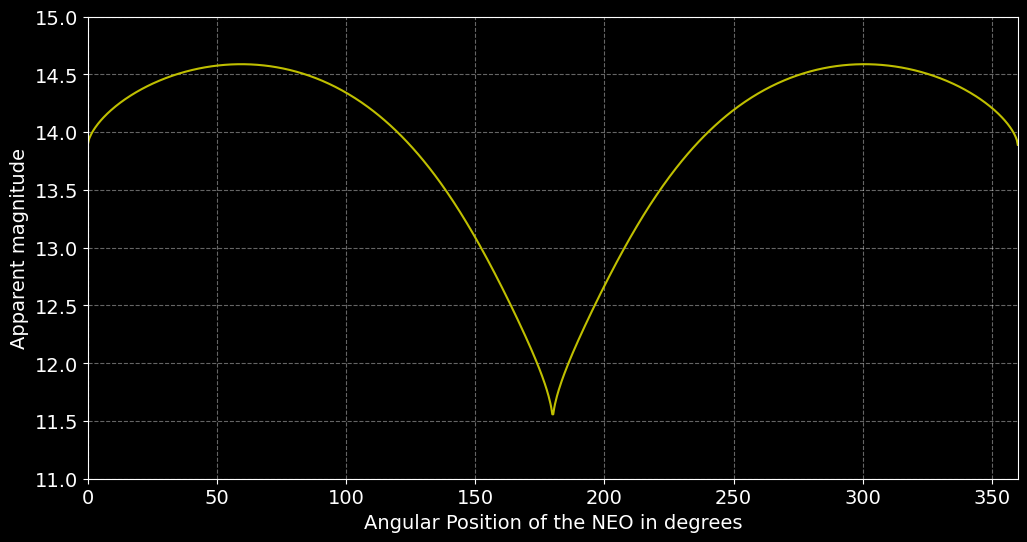

In [55]:
from matplotlib import pyplot as plt

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(12, 6))
plt.plot(phi_range, sample_app_mag, "y")

plt.grid(linestyle='dashed', alpha=0.4)

plt.xlabel("Angular Position of the NEO in degrees")
plt.ylabel("Apparent magnitude")

plt.xlim(0, 360)
plt.ylim(11, 15)

(11.0, 15.0)

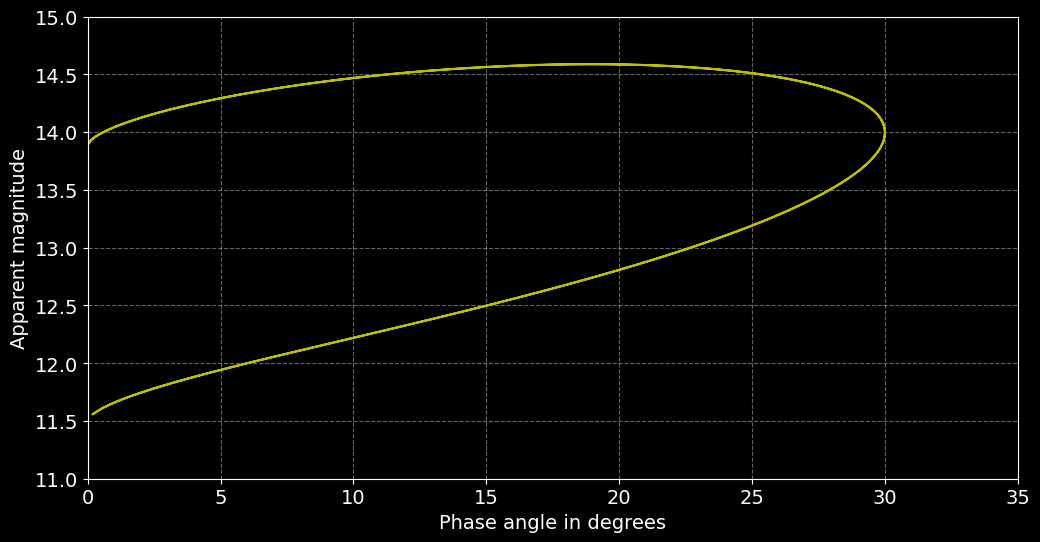

In [56]:
from matplotlib import pyplot as plt

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(12, 6))
plt.plot(sample_phase_angle, sample_app_mag, "y")

plt.grid(linestyle='dashed', alpha=0.4)

plt.xlabel("Phase angle in degrees")
plt.ylabel("Apparent magnitude")

plt.xlim(0, 35)
plt.ylim(11, 15)

In [57]:
# Compute the distance between the NEO and Earth
sample_dist_obj2obs = np.linalg.norm(sample_vec_obj2obs, axis=1)

(0.0, 35.0)

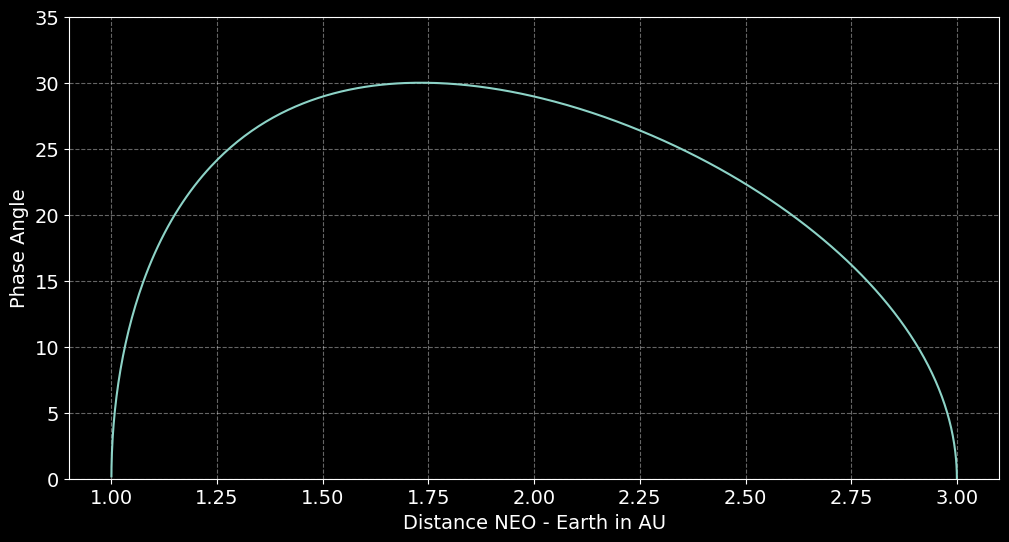

In [58]:
from matplotlib import pyplot as plt

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(12, 6))

plt.plot(sample_dist_obj2obs[:500], sample_phase_angle[:500])

plt.grid(linestyle='dashed', alpha=0.4)
plt.xlabel("Distance NEO - Earth in AU")
plt.ylabel("Phase Angle")
plt.xlim(0.9, 3.1)
plt.ylim(0, 35)